In [4]:
#!pip install -q imdb-sqlite
#!pip install -q pycountry

In [5]:
# imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [6]:
%%time
!imdb-sqlite

Wall time: 218 ms


2022-04-24 19:09:36,833 DB already exists: (imdb.db). Refusing to modify. Exiting


Carregamento dos Dados

In [7]:
connection = sqlite3.connect("imdb.db")

In [8]:
tables = pd.read_sql_query("select name as 'Table_Name' from sqlite_master where type = 'table'", connection)
tables = tables["Table_Name"].values.tolist()

In [9]:
for table in tables:
    query = "PRAGMA TABLE_INFO({})".format(table)
    result = pd.read_sql_query(query, connection)
    print("Esquema da tabela:", table)
    display(result)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




1 - Quais são as categorias de filmes mais comuns no IMDB?

In [10]:
query1 = '''select type, count(*) as count from titles group by type order by 2 desc'''
result1 = pd.read_sql_query(query1, connection)
display("result1:", result1)

'result1:'

,type,count
0,tvEpisode,6651598
1,short,865592
2,movie,607710
3,video,259395
4,tvSeries,223734
5,tvMovie,135795
6,tvMiniSeries,43068
7,tvSpecial,36603
8,videoGame,30921
9,tvShort,10524


In [11]:
result1['percent'] = (result1['count'] / result1['count'].sum()) * 100
display(result1)

,type,count,percent
0,tvEpisode,6651598,75.032617
1,short,865592,9.764215
2,movie,607710,6.855206
3,video,259395,2.926077
4,tvSeries,223734,2.523807
5,tvMovie,135795,1.531821
6,tvMiniSeries,43068,0.485824
7,tvSpecial,36603,0.412896
8,videoGame,30921,0.348801
9,tvShort,10524,0.118715


In [12]:
others = {}
others['count'] = result1[result1['percent'] < 6]['count'].sum()
others['percent'] = result1[result1['percent'] < 6]['percent'].sum()
others['type'] = 'others'

In [13]:
result1 = result1[result1['percent'] >= 6]
result1 = result1.append(others, ignore_index=True)
result1 = result1.sort_values(by='percent', ascending=False)
display(result1)

,type,count,percent
0,tvEpisode,6651598,75.032617
1,short,865592,9.764215
3,others,740042,8.347962
2,movie,607710,6.855206


In [14]:
#Ajustar labels
labels = [str(result1['type'][i]).capitalize()+' ['+str(round(result1['percent'][i], 2))+'%]' for i in result1.index]
labels

['Tvepisode [75.03%]', 'Short [9.76%]', 'Others [8.35%]', 'Movie [6.86%]']

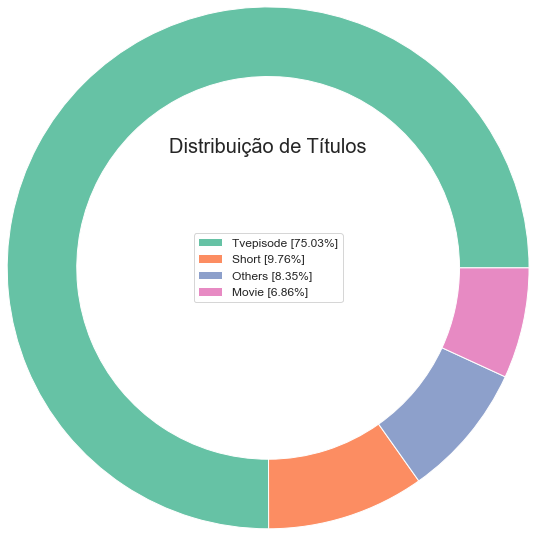

In [15]:
cs = cm.Set2(np.arange(100))
f = plt.figure()

plt.pie(result1['count'], labeldistance=1, radius=3, colors=cs, wedgeprops=dict(width=0.8))
plt.legend(labels=labels, loc='center', prop={'size':12})
plt.title("Distribuição de Títulos", loc='Center', fontdict={'fontsize':20, 'fontweight':20})
plt.show()

2 - Qual o número de títulos por gênero?

In [16]:
query2 = '''SELECT genres, COUNT(*) as count FROM titles WHERE type = 'movie' GROUP BY 1'''
result2 = pd.read_sql_query(query2, connection)

In [17]:
display(result2)

,genres,count
0,Action,13973
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1454,"Thriller,Western",43
1455,War,1293
1456,"War,Western",14
1457,Western,5153


In [18]:
result2['genres'] = result2['genres'].str.lower().values
temp = result2['genres'].dropna()

In [19]:
pattern = '(?u)\\b[\\w-]+\\b'
vector = CountVectorizer(token_pattern=pattern, analyzer='word').fit(temp)
vector

CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b')

In [20]:
bag_genres = vector.transform(temp)
unique_genres = vector.get_feature_names()
genres = pd.DataFrame(bag_genres.todense(), columns=unique_genres, index=temp.index)
genres = genres.drop(columns='n', axis=0)
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1459 non-null   int64
 1   adult        1459 non-null   int64
 2   adventure    1459 non-null   int64
 3   animation    1459 non-null   int64
 4   biography    1459 non-null   int64
 5   comedy       1459 non-null   int64
 6   crime        1459 non-null   int64
 7   documentary  1459 non-null   int64
 8   drama        1459 non-null   int64
 9   family       1459 non-null   int64
 10  fantasy      1459 non-null   int64
 11  film-noir    1459 non-null   int64
 12  game-show    1459 non-null   int64
 13  history      1459 non-null   int64
 14  horror       1459 non-null   int64
 15  music        1459 non-null   int64
 16  musical      1459 non-null   int64
 17  mystery      1459 non-null   int64
 18  news         1459 non-null   int64
 19  reality-tv   1459 non-null   int64
 20  romance 

In [21]:
genres_percent = 100 * pd.Series(genres.sum()).sort_values(ascending=False) / genres.shape[0]
genres_percent.head(10)

drama          18.094585
comedy         16.792324
documentary    15.764222
adventure      14.804661
action         14.461960
romance        13.296779
crime          13.159698
mystery        12.542838
thriller       12.268677
fantasy        12.131597
dtype: float64

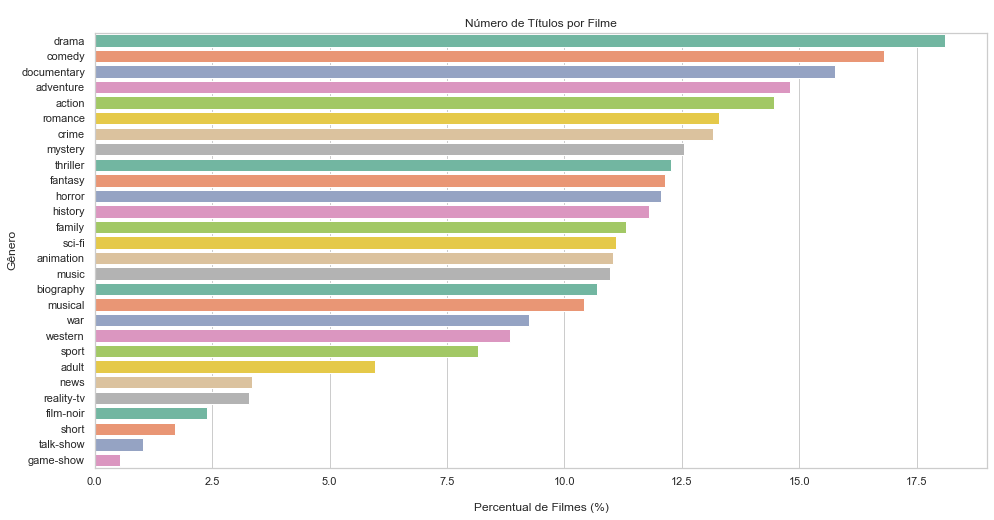

In [22]:
plt.figure(figsize=(16,8))
sns.barplot(x=genres_percent, y=genres_percent.index, orient='h', palette='Set2')
plt.ylabel('Gênero')
plt.xlabel('\nPercentual de Filmes (%)')
plt.title('\nNúmero de Títulos por Filme')
plt.show()

3 - Qual a mediana de avaliações dos files por gênero?

In [23]:
query3 = '''
        SELECT
            rating, genres
        FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
        WHERE
            premiered <= 2022 AND type = 'movie'
        '''
result3 = pd.read_sql_query(query3, connection)

In [24]:
display(result3)


,rating,genres
0,4.5,\N
1,6.0,"Action,Adventure,Biography"
2,4.6,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
277280,5.8,Thriller
277281,6.4,"Drama,History"
277282,3.6,"Adventure,History,War"
277283,8.3,Drama


In [25]:
#Função retorna unicos
def list_unique_genres(values):
    values['genres'] = values['genres'].str.lower().values
    temp = values['genres'].dropna()
    vector = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
    unique_genres = vector.get_feature_names()
    unique_genres = [genre for genre in unique_genres if len(genre) > 1]
    return unique_genres

In [26]:
unique_genres3 = list_unique_genres(result3)
display(unique_genres3)

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [27]:
genres_counts = []
genres_ratings = []

In [28]:
for typeMovie in unique_genres3:

    #Contagem
    query_count = "SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '%" + typeMovie + "%' AND type = 'movie'"
    result_count = pd.read_sql_query(query_count, connection)
    genres_counts.append(result_count.values[0][0])

    #Avaliação
    query_rating = "SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '%" + typeMovie + "%' AND type = 'movie'"
    result_rating = pd.read_sql_query(query_rating, connection)
    genres_ratings.append(np.median(result_rating['rating']))

In [29]:
print("CONTAGEM")
display(genres_counts)
print("AVALIACAO")
display(genres_ratings)

CONTAGEM


[28693,
 4366,
 17421,
 4761,
 8428,
 68622,
 23681,
 41349,
 122795,
 10721,
 8210,
 764,
 4,
 7654,
 19726,
 12573,
 6229,
 10369,
 654,
 46,
 30792,
 6574,
 22,
 3316,
 10,
 22712,
 5934,
 5067]

AVALIACAO


[5.8,
 5.9,
 6.0,
 6.6,
 7.0,
 6.0,
 6.1,
 7.3,
 6.3,
 6.3,
 6.0,
 6.5,
 6.800000000000001,
 6.9,
 5.0,
 6.5,
 6.2,
 6.0,
 7.3,
 6.0,
 6.2,
 5.4,
 7.15,
 6.7,
 7.0,
 5.6,
 6.6,
 6.0]

In [30]:
df_genres_ratings = pd.DataFrame()
df_genres_ratings['genres'] = unique_genres3
df_genres_ratings['count'] = genres_counts
df_genres_ratings['rating'] = genres_ratings

In [31]:
df_genres_ratings
df_genres_ratings.head(20)

,genres,count,rating
0,action,28693,5.8
1,adult,4366,5.9
2,adventure,17421,6.0
3,animation,4761,6.6
4,biography,8428,7.0
5,comedy,68622,6.0
6,crime,23681,6.1
7,documentary,41349,7.3
8,drama,122795,6.3
9,family,10721,6.3


In [32]:
if df_genres_ratings.index.__contains__(18):
    print('entrou')
    df_genres_ratings = df_genres_ratings.drop(index=18)
df_genres_ratings = df_genres_ratings.sort_values(by='rating', ascending=False)
df_genres_ratings.head(20)

entrou


,genres,count,rating
7,documentary,41349,7.30
22,short,22,7.15
4,biography,8428,7.00
24,talk-show,10,7.00
13,history,7654,6.90
12,game-show,4,6.80
23,sport,3316,6.70
26,war,5934,6.60
3,animation,4761,6.60
11,film-noir,764,6.50


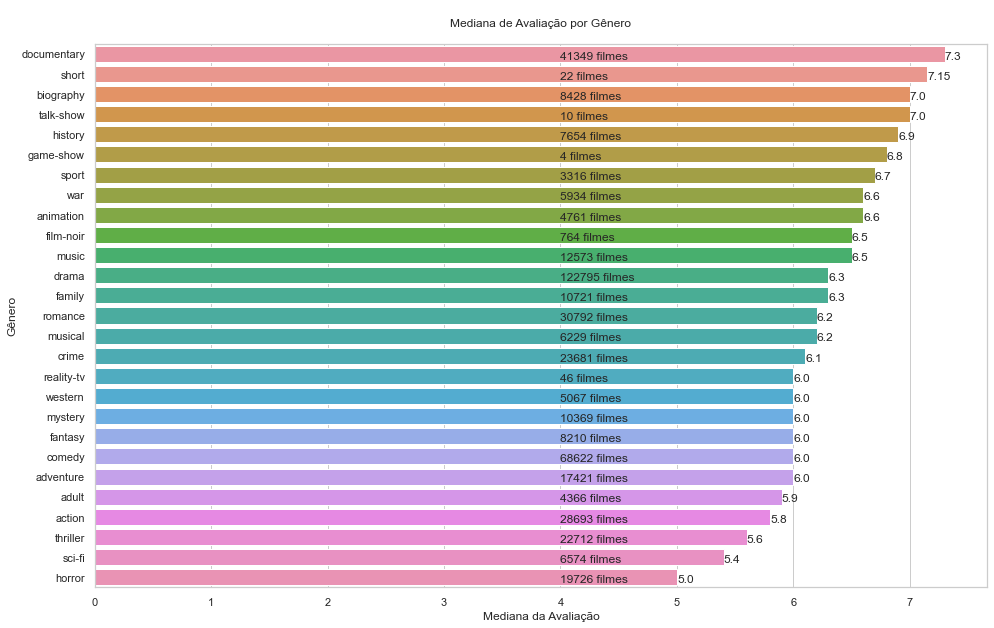

In [33]:
#Gráfico
plt.figure(figsize=(16,10))
sns.barplot(y=df_genres_ratings.genres, x=df_genres_ratings.rating, orient='h')

#textos do gráfico
for i in range(len(df_genres_ratings.index)):
    plt.text(4.0, i+0.25, str(df_genres_ratings['count'][df_genres_ratings.index[i]]) + " filmes")
    plt.text(df_genres_ratings.rating[df_genres_ratings.index[i]], i+0.25, round(df_genres_ratings['rating'][df_genres_ratings.index[i]], 2))

plt.ylabel('Gênero')
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação por Gênero\n')
plt.show()

4 - Qual a mediana de avalição dos filmes em relação ao ano de estréia?

In [34]:
query4 = '''
        SELECT
            rating AS Rating, premiered
        FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
        WHERE
            premiered <= 2022 AND type = 'movie'
        ORDER BY
            premiered
        '''
result4 = pd.read_sql_query(query4, connection)

In [35]:
display(result4)

,Rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
277280,9.2,2022
277281,5.6,2022
277282,6.0,2022
277283,5.0,2022


In [36]:
ratings =[]
for year in set(result4['premiered']):
    ratings.append(np.median(result4[result4['premiered'] == year]['Rating']))
years = list(set(result4['premiered']))

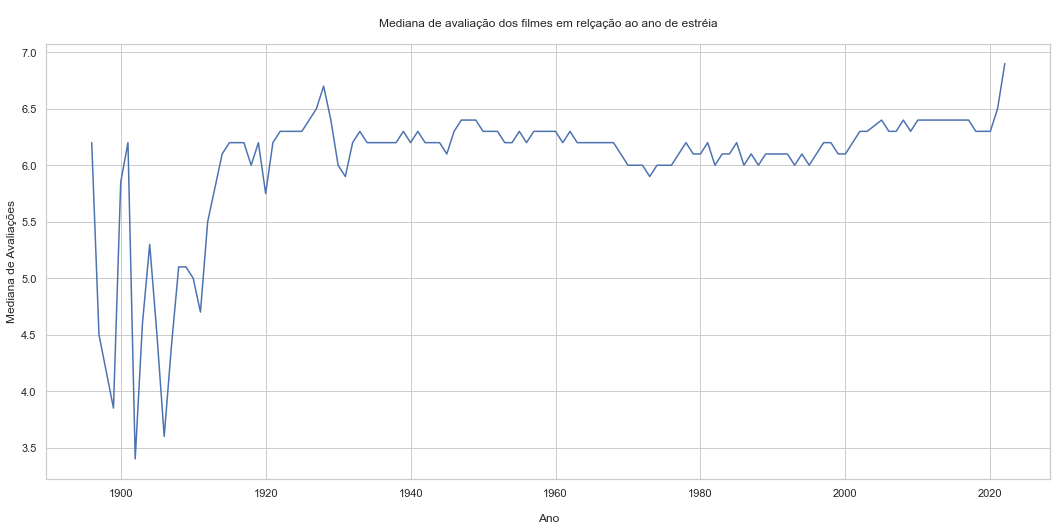

In [37]:
#Gáfico
plt.figure(figsize=(18,8))
plt.plot(years, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliações')
plt.title('\nMediana de avaliação dos filmes em relçação ao ano de estréia\n')
plt.show()

5 - Qual o número de filmes avaliados por gênero em relação ao ano de estréia?

In [38]:
query5 = '''SELECT genres FROM titles'''
result5 = pd.read_sql_query(query5, connection)
display(result5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8864937,"Action,Drama,Family"
8864938,"Action,Drama,Family"
8864939,"Action,Drama,Family"
8864940,Short


In [39]:
unique_genres5 = list_unique_genres(result5)

In [40]:
genres_count = []
for genre in unique_genres5:
    query = "SELECT COUNT(*) as count FROM titles WHERE genres LIKE '%" + genre + "%' AND type = 'movie' AND premiered <= 2022"
    result = pd.read_sql_query(query, connection)
    genres_count.append(result['count'].values[0])

In [41]:
df5_genres_count = pd.DataFrame()
df5_genres_count['genres'] = unique_genres5
df5_genres_count['count'] = genres_count

In [42]:
#Top 5
df5_genres_count = df5_genres_count[df5_genres_count['genres'] != 'n']
df5_genres_count = df5_genres_count.sort_values(by='count', ascending=False)
top_genres = df5_genres_count.head()['genres'].values

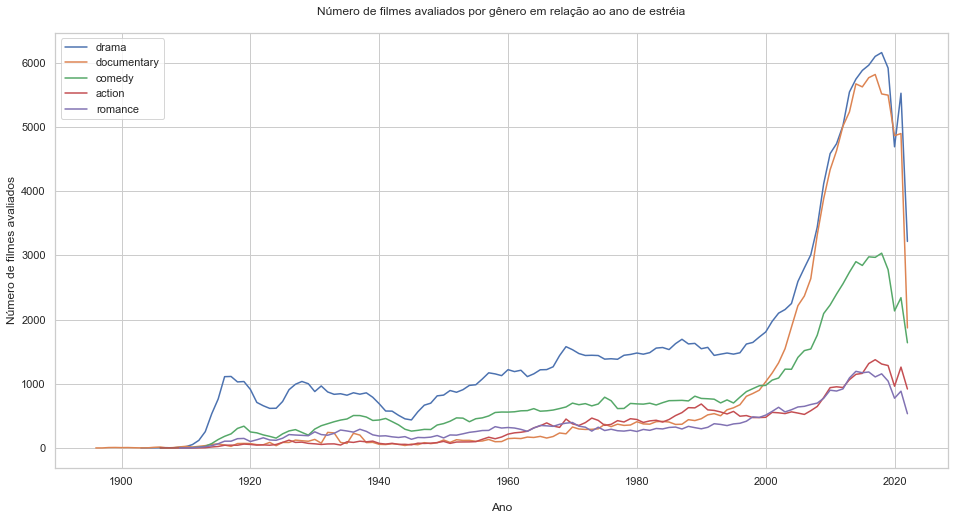

In [43]:
#Gráfico
plt.figure(figsize=(16,8))

for genre in top_genres:
    query = "SELECT COUNT(*) Number_of_movies, premiered Year FROM titles WHERE genres LIKe '%" + genre + "%'  AND type = 'movie' AND Year <= 2022 GROUP BY Year"
    result = pd.read_sql_query(query, connection)
    plt.plot(result['Year'], result['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de filmes avaliados')
plt.title('Número de filmes avaliados por gênero em relação ao ano de estréia\n')
plt.legend(labels=top_genres)
plt.show()

6 - Qual o filme com maior tempo de duração? Calcule os percentis.

In [44]:
query6 = '''
        SELECT
            runtime_minutes runtime
        FROM
            titles
        WHERE
            type = 'movie' AND runtime != 'NaN'
        '''
result6 = pd.read_sql_query(query6, connection)

In [45]:
display(result6)

,runtime
0,100
1,70
2,90
3,120
4,58
...,...
382348,123
382349,57
382350,100
382351,116


In [50]:
for i in range(101):
    perc = round(np.percentile(result6['runtime'].values, i), 2)
    print('{} percentil da duração (runtime) é: {}'.format(i, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 72.0
24 

In [55]:
query6 = '''
        SELECT
            runtime_minutes runtime, primary_title
        FROM
            titles
        WHERE
            type = 'movie' AND runtime != 'NaN'
        ORDER BY
            runtime DESC
        LIMIT 1
        '''
result6 = pd.read_sql_query(query6, connection)

In [56]:
display(result6)
print('O filme Logistics é um projeto realizado na Suíça em 2012 que rendeu o maior filme da historia até o momento com 51420 minutos.')

,runtime,primary_title
0,51420,Logistics


O filme Logistics é um projeto realizado na Suíça em 2012 que rendeu o maior filme da historia até o momento com 51420 minutos.


7 - Qual a relação entre duração e gênero?

In [59]:
query7 = '''
        SELECT
            AVG(runtime_minutes) runtime, genres
        FROM
            titles
        WHERE
            type = 'movie' AND runtime_minutes != 'NaN'
        GROUP BY
            genres
        '''
result7 = pd.read_sql_query(query7, connection)
display(result7)

,runtime,genres
0,99.320634,Action
1,77.000000,"Action,Adult"
2,69.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1369,93.928571,"Thriller,Western"
1370,93.986799,War
1371,90.000000,"War,Western"
1372,70.397565,Western


In [62]:
unique_genres7 = list_unique_genres(result7)

In [66]:
genre_runtime = []
for genre in unique_genres7:
    query = "SELECT runtime_minutes runtime FROM titles WHERE genres LIKE '%" + genre + "%' AND type = 'movie' AND runtime != 'NaN'"
    result = pd.read_sql_query(query, connection)
    genre_runtime.append(np.median(result['runtime']))

In [72]:
df_genres_runtime = pd.DataFrame()
df_genres_runtime['genre'] = unique_genres7
df_genres_runtime['runtime'] = genre_runtime

if df_genres_runtime.index.__contains__(18):
    df_genres_runtime = df_genres_runtime.drop(index=18)

df_genres_runtime = df_genres_runtime.sort_values(by='runtime', ascending=False)

In [73]:
display(df_genres_runtime)

,genre,runtime
20,romance,95.0
0,action,94.0
8,drama,93.0
16,musical,93.0
26,war,92.5
25,thriller,92.0
6,crime,92.0
5,comedy,91.0
17,mystery,91.0
15,music,90.0


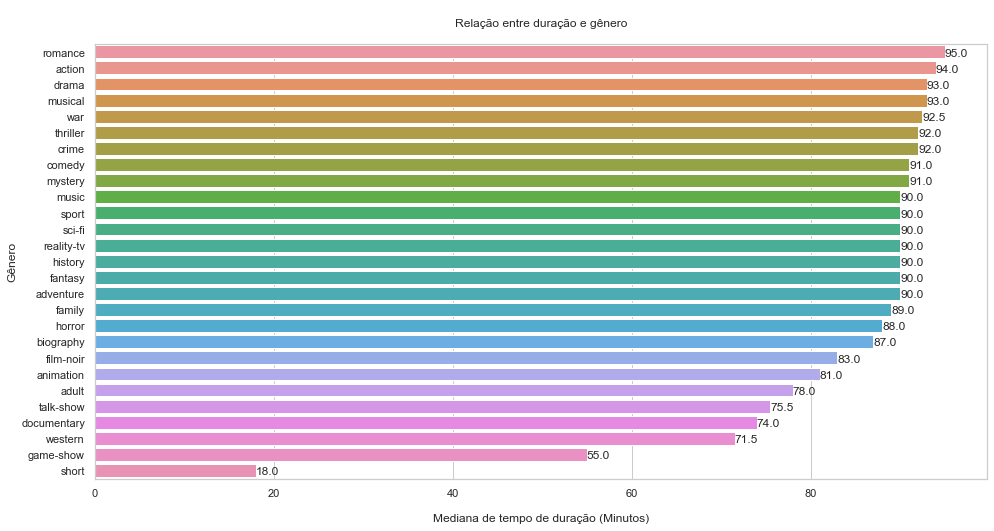

In [74]:
#Gráfico
plt.figure(figsize=(16,8))
sns.barplot(y=df_genres_runtime.genre, x=df_genres_runtime.runtime, orient='h')

for i in range(len(df_genres_runtime.index)):
    plt.text(df_genres_runtime.runtime[df_genres_runtime.index[i]], i+0.25, round(df_genres_runtime['runtime'][df_genres_runtime.index[i]], 2))

plt.ylabel('Gênero')
plt.xlabel('\nMediana de tempo de duração (Minutos)')
plt.title('\nRelação entre duração e gênero\n')
plt.show()

8 - Qual o número de filmes produzidos por país?

In [76]:
query8 = '''
        SELECT
            region, COUNT(*) number_of_movies
        FROM
            akas JOIN titles ON akas.title_id = titles.title_id
        WHERE
            region != 'None' AND type = 'movie'
        GROUP BY
            1
        '''
result8 = pd.read_sql_query(query8, connection)
display(result8)

,region,number_of_movies
0,AD,22
1,AE,6212
2,AF,113
3,AG,12
4,AL,1284
...,...,...
229,YUCS,153
230,ZA,3223
231,ZM,15
232,ZRCD,2


In [81]:
countries = []
count = []

In [82]:
for i in range(result8.shape[0]):
    try:
        country = result8['region'].values[i]
        countries.append(pycountry.countries.get(alpha_2=country).name)
        count.append(result8['number_of_movies'].values[i])
    except:
        continue

In [86]:
df_movies_countries = pd.DataFrame()
df_movies_countries['country'] = countries
df_movies_countries['movie_count'] = count

df_movies_countries = df_movies_countries.sort_values(by='movie_count', ascending=False)
df_movies_countries.head(10)

,country,movie_count
199,United States,310639
65,United Kingdom,159430
96,Japan,91291
63,France,84635
89,India,80961
32,Canada,77636
47,Germany,70725
26,Brazil,65465
93,Italy,65347
58,Spain,65343


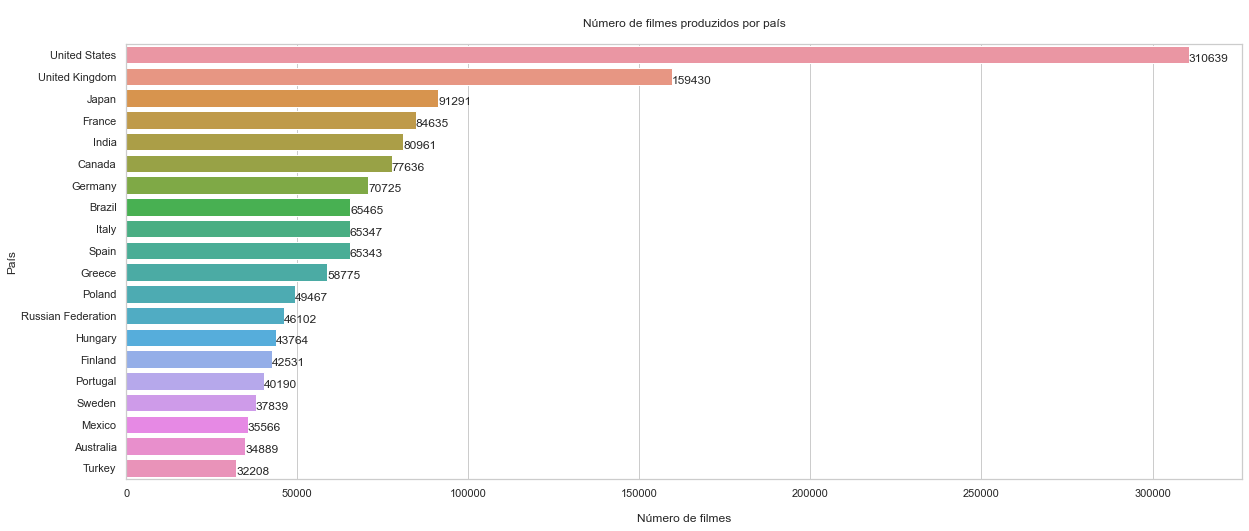

In [87]:
#Gráfico 

plt.figure(figsize=(20,8))
sns.barplot(y=df_movies_countries[:20].country, x=df_movies_countries[:20].movie_count, orient='h')

for i in range(0,20):
    plt.text(df_movies_countries.movie_count[df_movies_countries.index[i]]-1, i+0.30, round(df_movies_countries['movie_count'][df_movies_countries.index[i]], 2))

plt.ylabel('País')
plt.xlabel('\nNúmero de filmes')
plt.title('\nNúmero de filmes produzidos por país\n')
plt.show()

9 - Quais são os top 10 melhores filmes?

In [89]:
query9 = '''
        SELECT
            primary_title AS movie_name, genres, rating
        FROM
            titles JOIN ratings ON titles.title_id = ratings.title_id
        WHERE
            titles.type = 'movie' AND ratings.votes >= 25000
        ORDER BY rating DESC
        LIMIT 10
        '''
result9 = pd.read_sql_query(query9, connection)
display(result9)

,movie_name,genres,rating
0,K.G.F: Chapter 2,"Action,Crime,Drama",9.6
1,Jai Bhim,"Crime,Drama,Mystery",9.4
2,The Shawshank Redemption,Drama,9.3
3,The Chaos Class,"Comedy,Drama",9.3
4,The Godfather,"Crime,Drama",9.2
5,Soorarai Pottru,Drama,9.2
6,Mirror Game,"Crime,Mystery,Thriller",9.2
7,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
8,12 Angry Men,"Crime,Drama",9.0
9,The Godfather: Part II,"Crime,Drama",9.0


10 - Quais são os top 10 piores filmes?

In [90]:
query10 = '''
        SELECT
            primary_title AS movie_name, genres, rating
        FROM
            titles JOIN ratings ON titles.title_id = ratings.title_id
        WHERE
            titles.type = 'movie' AND ratings.votes >= 25000
        ORDER BY rating ASC
        LIMIT 10
        '''
result10 = pd.read_sql_query(query10, connection)
display(result10)

,movie_name,genres,rating
0,Cumali Ceber,Comedy,1.1
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
4,Manos: The Hands of Fate,Horror,1.6
5,Reis,"Biography,Drama",1.6
6,The Cost of Deception,"Crime,Drama,History",1.7
7,Justin Bieber: Never Say Never,"Documentary,Music",1.7
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
